## Import Libaries

In [1]:
# imports for the tutorial
import os
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
%matplotlib inline

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torchvision.utils as vutils

## Set random seed

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

## Create helper functions

In [3]:
"""
Helper Functions
"""

def calc_kl(logvar, mu, mu_o=0.0, logvar_o=0.0, reduce='sum'):
    """
    Calculate kl-divergence
    :param logvar: log-variance from the encoder
    :param mu: mean from the encoder
    :param mu_o: negative mean for outliers (hyper-parameter)
    :param logvar_o: negative log-variance for outliers (hyper-parameter)
    :param reduce: type of reduce: 'sum', 'none'
    :return: kld
    """
    if not isinstance(mu_o, torch.Tensor):
        mu_o = torch.tensor(mu_o).to(mu.device)
    if not isinstance(logvar_o, torch.Tensor):
        logvar_o = torch.tensor(logvar_o).to(mu.device)
    kl = -0.5 * (1 + logvar - logvar_o - logvar.exp() / torch.exp(logvar_o) - (mu - mu_o).pow(2) / torch.exp(
        logvar_o)).sum(1)
    if reduce == 'sum':
        kl = torch.sum(kl)
    elif reduce == 'mean':
        kl = torch.mean(kl)
    return kl


def reparameterize(mu, logvar):
    """
    This function applies the reparameterization trick:
    z = mu(X) + sigma(X)^0.5 * epsilon, where epsilon ~ N(0,I)
    :param mu: mean of x
    :param logvar: log variaance of x
    :return z: the sampled latent variable
    """
    device = mu.device
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(device)
    return mu + eps * std


def calc_reconstruction_loss(x, recon_x, loss_type='mse', reduction='sum'):
    """

    :param x: original inputs
    :param recon_x:  reconstruction of the VAE's input
    :param loss_type: "mse", "l1", "bce"
    :param reduction: "sum", "mean", "none"
    :return: recon_loss
    """
    if reduction not in ['sum', 'mean', 'none']:
        raise NotImplementedError
    recon_x = recon_x.view(recon_x.size(0), -1)
    x = x.view(x.size(0), -1)
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='none')
        recon_error = recon_error.sum(1)
        if reduction == 'sum':
            recon_error = recon_error.sum()
        elif reduction == 'mean':
            recon_error = recon_error.mean()
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction=reduction)
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction=reduction)
    else:
        raise NotImplementedError
    return recon_error


def load_model(model, pretrained, device):
    weights = torch.load(pretrained, map_location=device)
    model.load_state_dict(weights['model'], strict=False)


def save_checkpoint(model, epoch, iteration, prefix=""):
    model_out_path = "./saves/" + prefix + "model_epoch_{}_iter_{}.pth".format(epoch, iteration)
    state = {"epoch": epoch, "model": model.state_dict()}
    if not os.path.exists("./saves/"):
        os.makedirs("./saves/")

    torch.save(state, model_out_path)

    print("model checkpoint saved @ {}".format(model_out_path))

def classification(Dataset, class_set=[0, 1]):
    """
    Reduce or transform the dataset to specific lables dataset.
    
    class_set description:
    class_0 : airplane
    class_1 : automobile
    class_2 : bird
    class_3 : cat
    class_4 : deer
    class_5 : dog
    class_6 : frog
    class_7 : horse
    class_8 : ship
    class_9 : truck
  """

    class_idx = []

    for n, idx in enumerate(Dataset):
        if idx[1] in set(class_set):
            class_idx.append(n)

    new_Dataset = Subset(Dataset, list(class_idx))


    return new_Dataset

def load_trained_model(PATH, train_set, test_set):
    """
    Load the pre-trained parameters to the SoftIntorVAE.
    Also select the dataset relates to the model.
    """
    # reconstructions
    num_recon = 8
    train_dataset = CIFAR10(root='./cifar10_ds', train=True, download=True, transform=transforms.ToTensor())
    train_dataset = classification(train_dataset, class_set=train_set)
    train_loader = DataLoader(dataset=train_dataset, batch_size=num_recon, shuffle=False)

    test_dataset = CIFAR10(root='./cifar10_ds', train=False, download=True, transform=transforms.ToTensor())
    test_dataset = classification(test_dataset, class_set=test_set)
    test_loader = DataLoader(dataset=test_dataset, batch_size=num_recon, shuffle=True)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = SoftIntroVAE(cdim=3, zdim=128, channels=[64, 128, 256], image_size=32).to(device)
    
    model.load_state_dict(torch.load(PATH))
    
    return model, train_loader, test_loader

## Build the model 
- We select the Soft-Intro-VAE as the model.

In [4]:
"""
Models
"""
class _Residual_Block(nn.Module):
    """
    https://github.com/hhb072/IntroVAE
    Difference: self.bn2 on output and not on (output + identity)
    """

    def __init__(self, inc=64, outc=64, groups=1, scale=1.0):
        super(_Residual_Block, self).__init__()

        midc = int(outc * scale)

        if inc is not outc:
            self.conv_expand = nn.Conv2d(in_channels=inc, out_channels=outc, kernel_size=1, stride=1, padding=0,
                                         groups=1, bias=False)
        else:
            self.conv_expand = None

        self.conv1 = nn.Conv2d(in_channels=inc, out_channels=midc, kernel_size=3, stride=1, padding=1, groups=groups,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(midc)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(in_channels=midc, out_channels=outc, kernel_size=3, stride=1, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(outc)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        if self.conv_expand is not None:
            identity_data = self.conv_expand(x)
        else:
            identity_data = x

        output = self.relu1(self.bn1(self.conv1(x)))
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(torch.add(output, identity_data))
        # output = self.relu2(self.bn2(torch.add(output, identity_data)))
        return output


class Encoder(nn.Module):
    def __init__(self, cdim=3, zdim=512, channels=(64, 128, 256, 512, 512, 512), image_size=256, conditional=False):
        super(Encoder, self).__init__()

        assert (2 ** len(channels)) * 4 == image_size
        self.zdim = zdim
        self.conditional = conditional
        self.cond_dim = 10
        cc = channels[0]
        self.main = nn.Sequential(
            nn.Conv2d(cdim, cc, 5, 1, 2, bias=False),
            nn.BatchNorm2d(cc),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2),
        )

        sz = image_size // 2
        for ch in channels[1:]:
            self.main.add_module('res_in_{}'.format(sz), _Residual_Block(cc, ch, scale=1.0))
            self.main.add_module('down_to_{}'.format(sz // 2), nn.AvgPool2d(2))
            cc, sz = ch, sz // 2

        self.main.add_module('res_in_{}'.format(sz), _Residual_Block(cc, cc, scale=1.0))
        if self.conditional:
            self.fc = nn.Linear(cc * 4 * 4 + self.cond_dim, 2 * zdim)
        else:
            self.fc = nn.Linear(cc * 4 * 4, 2 * zdim)

    def forward(self, x, o_cond=None):
        y = self.main(x).view(x.size(0), -1)
        if self.conditional and o_cond is not None:
            y = torch.cat([y, o_cond], dim=1)
        y = self.fc(y)
        mu, logvar = y.chunk(2, dim=1)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, cdim=3, zdim=512, channels=(64, 128, 256, 512, 512, 512), image_size=256, conditional=False):
        super(Decoder, self).__init__()

        assert (2 ** len(channels)) * 4 == image_size
        self.conditional = conditional
        cc = channels[-1]
        self.cond_dim = 10
        if self.conditional:
            self.fc = nn.Sequential(
                nn.Linear(zdim + self.cond_dim, cc * 4 * 4),
                nn.ReLU(True),
            )
        else:
            self.fc = nn.Sequential(
                nn.Linear(zdim, cc * 4 * 4),
                nn.ReLU(True),
            )

        sz = 4

        self.main = nn.Sequential()
        for ch in channels[::-1]:
            self.main.add_module('res_in_{}'.format(sz), _Residual_Block(cc, ch, scale=1.0))
            self.main.add_module('up_to_{}'.format(sz * 2), nn.Upsample(scale_factor=2, mode='nearest'))
            cc, sz = ch, sz * 2

        self.main.add_module('res_in_{}'.format(sz), _Residual_Block(cc, cc, scale=1.0))
        self.main.add_module('predict', nn.Conv2d(cc, cdim, 5, 1, 2))

    def forward(self, z, y_cond=None):
        z = z.view(z.size(0), -1)
        if self.conditional and y_cond is not None:
            y_cond = y_cond.view(y_cond.size(0), -1)
            z = torch.cat([z, y_cond], dim=1)
        y = self.fc(z)
        y = y.view(z.size(0), -1, 4, 4)
        y = self.main(y)
        return y

In [5]:
class SoftIntroVAE(nn.Module):
    def __init__(self, cdim=3, zdim=512, channels=(64, 128, 256, 512, 512, 512), image_size=256, conditional=False):
        super(SoftIntroVAE, self).__init__()

        self.zdim = zdim
        self.conditional = conditional

        self.encoder = Encoder(cdim, zdim, channels, image_size, conditional=conditional)

        self.decoder = Decoder(cdim, zdim, channels, image_size, conditional=conditional)

    def forward(self, x, o_cond=None, deterministic=False):
        if self.conditional and o_cond is not None:
            mu, logvar = self.encode(x, o_cond=o_cond)
            if deterministic:
                z = mu
            else:
                z = reparameterize(mu, logvar)
            y = self.decode(z, y_cond=o_cond)
            return mu, logvar, z, y
        else:
            mu, logvar = self.encode(x)
            if deterministic:
                z = mu
            else:
                z = reparameterize(mu, logvar)
            y = self.decode(z)
            return mu, logvar, z, y

    def sample(self, z, y_cond=None):
        y = self.decode(z, y_cond=y_cond)
        return y

    def sample_with_noise(self, num_samples=1, device=torch.device("cpu"), y_cond=None):
        z = torch.randn(num_samples, self.z_dim).to(device)
        return self.decode(z, y_cond=y_cond)

    def encode(self, x, o_cond=None):
        if self.conditional and o_cond is not None:
            mu, logvar = self.encoder(x, o_cond=o_cond)
        else:
            mu, logvar = self.encoder(x)
        return mu, logvar

    def decode(self, z, y_cond=None):
        if self.conditional and y_cond is not None:
            y = self.decoder(z, y_cond=y_cond)
        else:
            y = self.decoder(z)
        return y

## Define a training function

In [6]:
def train_soft_intro_vae(dataset='cifar10', z_dim=128, lr_e=2e-4, lr_d=2e-4, batch_size=128, num_workers=4, start_epoch=0,
                       num_epochs=250, num_vae=0, save_interval=5000, recon_loss_type="mse",
                       beta_kl=1.0, beta_rec=1.0, beta_neg=1.0, test_iter=1000, seed=-1, pretrained=None,
                       device=torch.device("cpu"), num_row=8, gamma_r=1e-8, class_set=[0, 1]):
    if seed != -1:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        print("random seed: ", seed)

    # --------------build models -------------------------
    if dataset == 'cifar10':
        image_size = 32
        channels = [64, 128, 256]
        train_set = CIFAR10(root='./cifar10_ds', train=True, download=True, transform=transforms.ToTensor())
        ch = 3
    elif dataset == 'svhn':
        image_size = 32
        channels = [64, 128, 256]
        train_set = SVHN(root='./svhn', split='train', transform=transforms.ToTensor(), download=True)
        ch = 3
    elif dataset == 'customize': # Select the dataset 
        image_size = 32
        channels = [64, 128, 256]
        train_set = CIFAR10(root='./cifar10_ds', train=True, download=True, transform=transforms.ToTensor())
        ch = 3
        train_set = classification(train_set, class_set=class_set)
    else:
        raise NotImplementedError("dataset is not supported")

    model = SoftIntroVAE(cdim=ch, zdim=z_dim, channels=channels, image_size=image_size).to(device)
    if pretrained is not None:
        load_model(model, pretrained, device)
    # print(model)

    optimizer_e = optim.Adam(model.encoder.parameters(), lr=lr_e)
    optimizer_d = optim.Adam(model.decoder.parameters(), lr=lr_d)

    e_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_e, milestones=(350,), gamma=0.1)
    d_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_d, milestones=(350,), gamma=0.1)

    scale = 1 / (ch * image_size ** 2)  # normalizing constant, 's' in the paper

    train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    start_time = time.time()

    cur_iter = 0
    kls_real = []
    kls_fake = []
    kls_rec = []
    rec_errs = []

    for epoch in range(start_epoch, num_epochs):
        diff_kls = []
        # save models
        if epoch % save_interval == 0 and epoch > 0:
            save_epoch = (epoch // save_interval) * save_interval
            prefix = dataset + "_soft_intro_vae" + "_betas_" + str(beta_kl) + "_" + str(beta_neg) + "_" + str(
                beta_rec) + "_"
            save_checkpoint(model, save_epoch, cur_iter, prefix)

        model.train()
        batch_kls_real = []
        batch_kls_fake = []
        batch_kls_rec = []
        batch_rec_errs = []

        for iteration, batch in enumerate(train_data_loader, 0):
            # --------------train------------
            if dataset == "cifar10" or dataset == 'customize':
                batch = batch[0]
            if epoch < num_vae:
                # vanilla vae training
                if len(batch.size()) == 3:
                    batch = batch.unsqueeze(0)

                batch_size = batch.size(0)

                real_batch = batch.to(device)

                # =========== Update E, D ================

                real_mu, real_logvar, z, rec = model(real_batch)

                loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type=recon_loss_type, reduction="mean")
                loss_kl = calc_kl(real_logvar, real_mu, reduce="mean")

                loss = beta_rec * loss_rec + beta_kl * loss_kl

                optimizer_e.zero_grad()
                optimizer_d.zero_grad()
                loss.backward()
                optimizer_e.step()
                optimizer_d.step()

                if iteration % test_iter == 0:
                    info = "\nEpoch[{}]({}/{}): time: {:4.4f}: ".format(epoch, iteration, len(train_data_loader),
                                                                        time.time() - start_time)
                    info += 'Rec: {:.4f}, KL: {:.4f}, '.format(loss_rec.data.cpu(), loss_kl.data.cpu())
                    print(info)
                    vutils.save_image(torch.cat([real_batch, rec], dim=0).data.cpu(),
                                          '{}/image_{}.jpg'.format("./", cur_iter), nrow=num_row)

            else:
                # soft-intro-vae training
                if len(batch.size()) == 3:
                    batch = batch.unsqueeze(0)

                b_size = batch.size(0)

                # generate random noise to produce 'fake' later
                noise_batch = torch.randn(size=(b_size, z_dim)).to(device)
                real_batch = batch.to(device)

                # =========== Update E ================
                for param in model.encoder.parameters():
                    param.requires_grad = True
                for param in model.decoder.parameters():
                    param.requires_grad = False

                # generate 'fake' data
                fake = model.sample(noise_batch)

                # ELBO for real data
                real_mu, real_logvar = model.encode(real_batch)
                z = reparameterize(real_mu, real_logvar)
                rec = model.decoder(z)

                loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type=recon_loss_type, reduction="mean")
                lossE_real_kl = calc_kl(real_logvar, real_mu, reduce="mean")

                # prepare 'fake' data for expELBO
                rec_mu, rec_logvar, z_rec, rec_rec = model(rec.detach())
                fake_mu, fake_logvar, z_fake, rec_fake = model(fake.detach())

                # KLD loss for the fake data
                fake_kl_e = calc_kl(fake_logvar, fake_mu, reduce="none")
                rec_kl_e = calc_kl(rec_logvar, rec_mu, reduce="none")

                # reconstruction loss for the fake data
                loss_fake_rec = calc_reconstruction_loss(fake, rec_fake, loss_type=recon_loss_type, reduction="none")
                loss_rec_rec = calc_reconstruction_loss(rec, rec_rec, loss_type=recon_loss_type, reduction="none")

                # expELBO
                exp_elbo_fake = (-2 * scale * (beta_rec * loss_fake_rec + beta_neg * fake_kl_e)).exp().mean()
                exp_elbo_rec = (-2 * scale * (beta_rec * loss_rec_rec + beta_neg * rec_kl_e)).exp().mean()

                # total loss
                lossE = scale * (beta_rec * loss_rec + beta_kl * lossE_real_kl) + 0.25 * (exp_elbo_fake + exp_elbo_rec)

                # backprop
                optimizer_e.zero_grad()
                lossE.backward()
                optimizer_e.step()

                # ========= Update D ==================
                for param in model.encoder.parameters():
                    param.requires_grad = False
                for param in model.decoder.parameters():
                    param.requires_grad = True

                # generate 'fake' data
                fake = model.sample(noise_batch)
                rec = model.decoder(z.detach())

                 # ELBO loss for real -- just the reconstruction, KLD for real doesn't affect the decoder
                loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type=recon_loss_type, reduction="mean")

                # prepare 'fake' data for the ELBO
                rec_mu, rec_logvar = model.encode(rec)
                z_rec = reparameterize(rec_mu, rec_logvar)

                fake_mu, fake_logvar = model.encode(fake)
                z_fake = reparameterize(fake_mu, fake_logvar)

                rec_rec = model.decode(z_rec.detach())
                rec_fake = model.decode(z_fake.detach())

                loss_rec_rec = calc_reconstruction_loss(rec.detach(), rec_rec, loss_type=recon_loss_type,
                                                        reduction="mean")
                loss_fake_rec = calc_reconstruction_loss(fake.detach(), rec_fake, loss_type=recon_loss_type,
                                                         reduction="mean")

                rec_kl = calc_kl(rec_logvar, rec_mu, reduce="mean")
                fake_kl = calc_kl(fake_logvar, fake_mu, reduce="mean")

                lossD = scale * (loss_rec * beta_rec + (rec_kl + fake_kl) * 0.5 * beta_kl + \
                                             gamma_r * 0.5 * beta_rec * (loss_rec_rec + loss_fake_rec))

                optimizer_d.zero_grad()
                lossD.backward()
                optimizer_d.step()
                if torch.isnan(lossD) or torch.isnan(lossE):
                    raise SystemError

                # statistics for plotting later
                diff_kls.append(-lossE_real_kl.data.cpu().item() + fake_kl.data.cpu().item())
                batch_kls_real.append(lossE_real_kl.data.cpu().item())
                batch_kls_fake.append(fake_kl.cpu().item())
                batch_kls_rec.append(rec_kl.data.cpu().item())
                batch_rec_errs.append(loss_rec.data.cpu().item())

                if cur_iter % test_iter == 0:
                    info = "\nEpoch[{}]({}/{}): time: {:4.4f}: ".format(epoch, iteration, len(train_data_loader),
                                                                        time.time() - start_time)
                    info += 'Rec: {:.4f}, '.format(loss_rec.data.cpu())
                    info += 'Kl_E: {:.4f}, expELBO_R: {:.4e}, expELBO_F: {:.4e}, '.format(lossE_real_kl.data.cpu(),
                                                                                    exp_elbo_rec.data.cpu(),
                                                                                    exp_elbo_fake.cpu())
                    info += 'Kl_F: {:.4f}, KL_R: {:.4f}'.format(rec_kl.data.cpu(), fake_kl.data.cpu())
                    info += ' DIFF_Kl_F: {:.4f}'.format(-lossE_real_kl.data.cpu() + fake_kl.data.cpu())
                    print(info)

                    _, _, _, rec_det = model(real_batch, deterministic=True)
                    max_imgs = min(batch.size(0), 16)
                    vutils.save_image(
                            torch.cat([real_batch[:max_imgs], rec_det[:max_imgs], fake[:max_imgs]], dim=0).data.cpu(),
                            '{}/image_{}.jpg'.format("./", cur_iter), nrow=num_row)
            cur_iter += 1
        e_scheduler.step()
        d_scheduler.step()

        if epoch > num_vae - 1:
            kls_real.append(np.mean(batch_kls_real))
            kls_fake.append(np.mean(batch_kls_fake))
            kls_rec.append(np.mean(batch_kls_rec))
            rec_errs.append(np.mean(batch_rec_errs))

        if epoch == num_epochs - 1:
            with torch.no_grad():
                _, _, _, rec_det = model(real_batch, deterministic=True)
                noise_batch = torch.randn(size=(b_size, z_dim)).to(device)
                fake = model.sample(noise_batch)
                max_imgs = min(batch.size(0), 16)
                vutils.save_image(
                        torch.cat([real_batch[:max_imgs], rec_det[:max_imgs], fake[:max_imgs]], dim=0).data.cpu(),
                        '{}/image_{}.jpg'.format("./", cur_iter), nrow=num_row)

            # plot graphs
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            ax.plot(np.arange(len(kls_real)), kls_real, label="kl_real")
            ax.plot(np.arange(len(kls_fake)), kls_fake, label="kl_fake")
            ax.plot(np.arange(len(kls_rec)), kls_rec, label="kl_rec")
            ax.plot(np.arange(len(rec_errs)), rec_errs, label="rec_err")
            ax.set_ylim([0, 200])
            ax.legend()
            plt.savefig('./soft_intro_vae_train_graphs.jpg')
            # save models
            prefix = dataset + "_soft_intro_vae" + "_betas_" + str(beta_kl) + "_" + str(beta_neg) + "_" + str(
                beta_rec) + "_"
            save_checkpoint(model, epoch, cur_iter, prefix)
            plt.show()
    return model

## Create a plotting function

In [7]:
"""
Plot the training data
"""
def plot_kld(train_loader,
             test_loader,
             class_set,
             train_set,
             test_set,
             save=False):
    """
    Collect the hidden space distance - KLD loss 
    and plot the data using boxplot.
    
    Set 'save' param to 'True' in order to download boxplot information.
    
    """

    kld_table = {}
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for i in class_set:
        kld_table[f"train_{i}"] = []
        kld_table[f"test_{i}"] = []

    for iteration, batch in enumerate(train_loader, 0):
        labels = batch[1]
        batch = batch[0]
        for i in range(len(batch)):
            #batch = batch[i:i+1]
            label = int(labels[i])
            b_size = batch.size(0)
            real_batch = batch[i:i+1].to(device)
            real_mu, real_logvar = model.encode(real_batch)
            z = reparameterize(real_mu, real_logvar)
            rec = model.decoder(z)
            #loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type="mse", reduction="mean")
            lossE_real_kl = calc_kl(real_logvar, real_mu, reduce="mean")

            kld_table[f"train_{label}"].append(lossE_real_kl.item())
            #kld_recon_train.append(loss_rec.item())

    for iteration, batch in enumerate(test_loader, 0):
        labels = batch[1]
        batch = batch[0]
        for i in range(len(batch)):
            label = int(labels[i])
            b_size = batch.size(0)
            real_batch = batch[i:i+1].to(device)
            real_mu, real_logvar = model.encode(real_batch)
            z = reparameterize(real_mu, real_logvar)
            rec = model.decoder(z)
            #loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type="mse", reduction="mean")
            lossE_real_kl = calc_kl(real_logvar, real_mu, reduce="mean")

            kld_table[f"test_{label}"].append(lossE_real_kl.item())
            #kld_recon_test.append(loss_rec.item())

    df = pd.DataFrame()
    for class_type, value in kld_table.items():
        df_cat = pd.DataFrame({'value': value})
        df_cat['class_type'] = class_type[:-2]
        df_cat['label'] = class_type[-1:]
        df = pd.concat([df, df_cat])


    plt.figure(iteration)
    #data = pd.DataFrame()

    g = sns.catplot(data=df, kind='box', x='label', y='value',
            hue='class_type', height=8, aspect=1.5)

    for i in class_set:

        train_len = len(df[(df['label'] == f'{i}') & (df['class_type'] == 'train')])
        test_len = len(df[(df['label'] == f'{i}') & (df['class_type'] == 'test')])
        plt.text(i-0.13, -45, f'Num_train:\n  {train_len}')
        plt.text(i-0.13, -75, f'Num_test:\n {test_len}')


    plt.ylim(0,600)
    plt.title(f'model : {train_set}')
    if save == True:
        plt.savefig(f'model_{train_set}.png')

#plot_kld(train_loader, test_loader, class_set=[0,1])

In [8]:
"""
train_set = [0]
test_set = [0,1,2,3,4,5,6,7,8,9]
"""

'\ntrain_set = [0]\ntest_set = [0,1,2,3,4,5,6,7,8,9]\n'

In [9]:
"""
PATH = '/kaggle/input/model-param-cifar10/model_param/model_label_0.pt'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
"""

'\nPATH = \'/kaggle/input/model-param-cifar10/model_param/model_label_0.pt\'\ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\n'

In [10]:
"""
model, train_loader, test_loader = load_trained_model(PATH, train_set, test_set)
plot_kld(train_loader, test_loader,class_set=test_set, train_set=train_set,test_set=test_set,
         save=True)
"""

'\nmodel, train_loader, test_loader = load_trained_model(PATH, train_set, test_set)\nplot_kld(train_loader, test_loader,class_set=test_set, train_set=train_set,test_set=test_set,\n         save=True)\n'

## Plot each testing data with specific pretrained model

In [11]:
"""
NOTE:
'train_set_order' is the order relates to the pre-trained model.

e.g.
order : 0 with model_0
order : 1 with model_1
order : 2,3,4,5,6,7 with model_bio
and so on
"""

files = glob.glob("/kaggle/input/model-param-cifar10/model_param/*.pt")
test_set = [0,1,2,3,4,5,6,7,8,9]
train_set_order =[[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],
           [0,1,2,3,4,5,6,7,8,9],[2,3,4,5,6,7],[0,1,8,9]]

100%|██████████| 170498071/170498071 [00:01<00:00, 94724892.00it/s] 


Extracting ./cifar10_ds/cifar-10-python.tar.gz to ./cifar10_ds
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded 

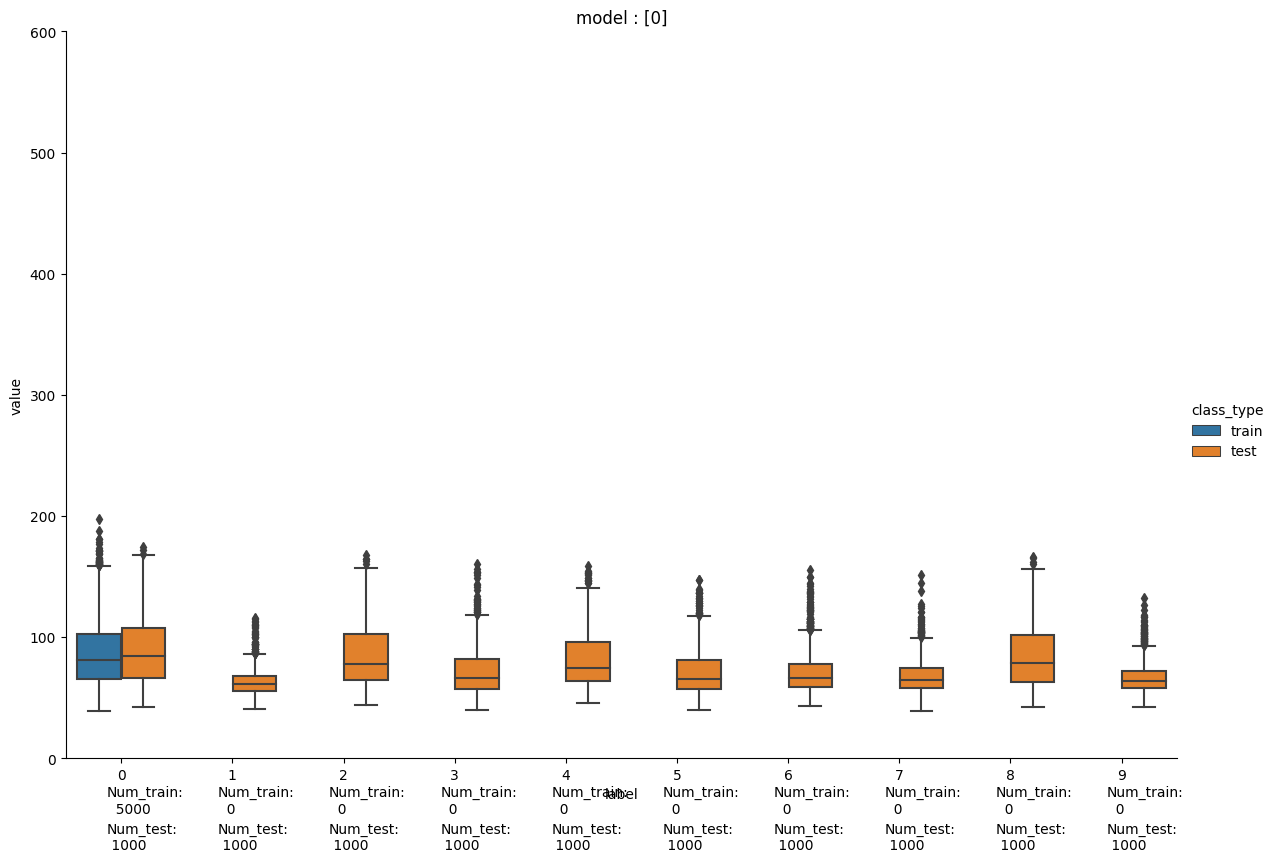

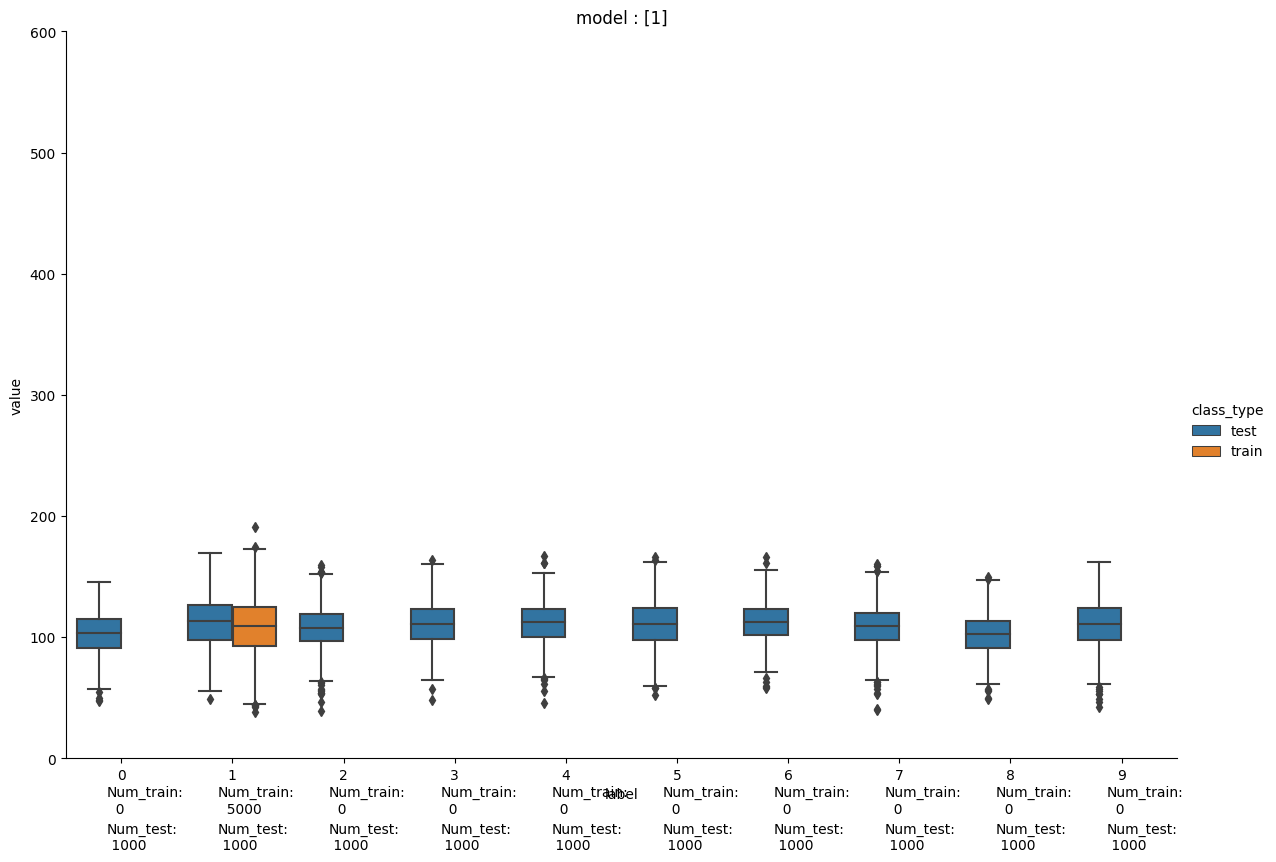

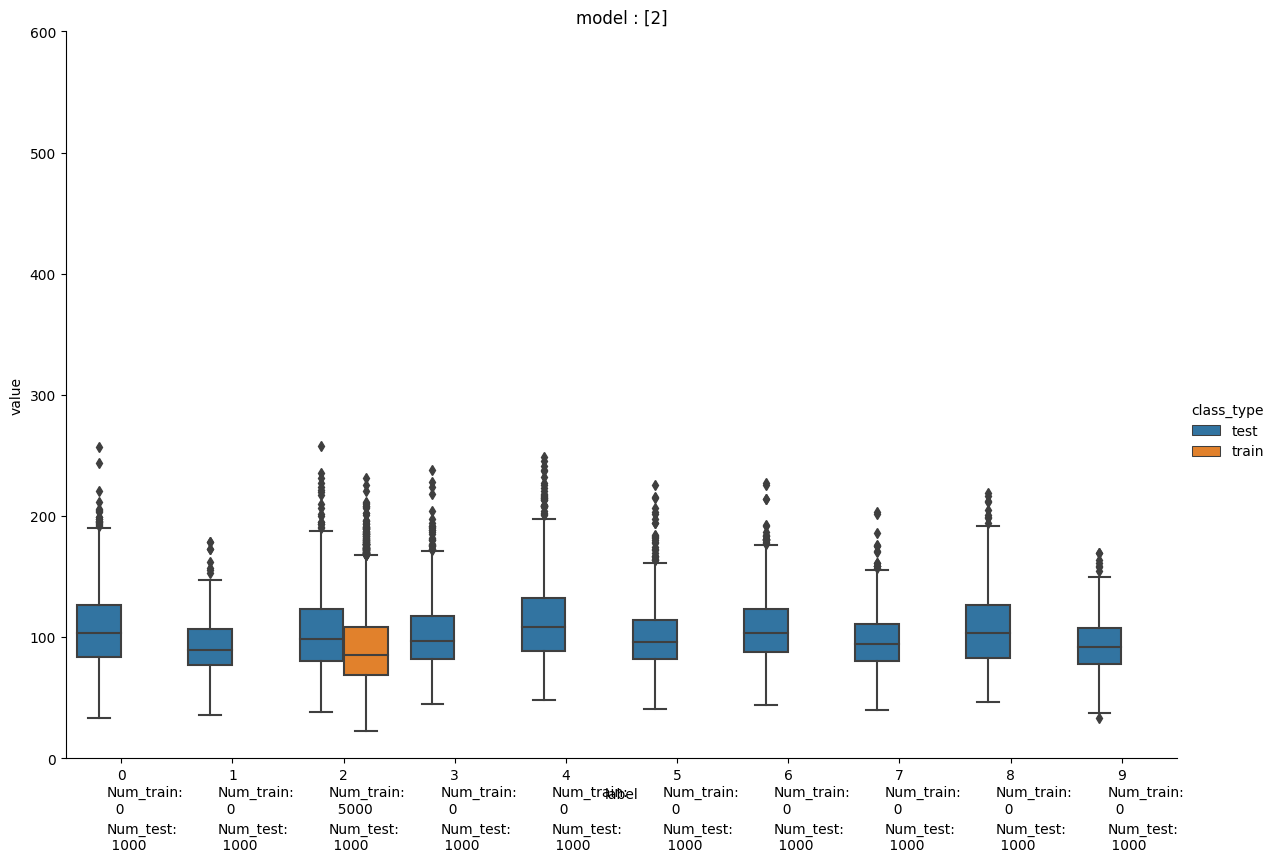

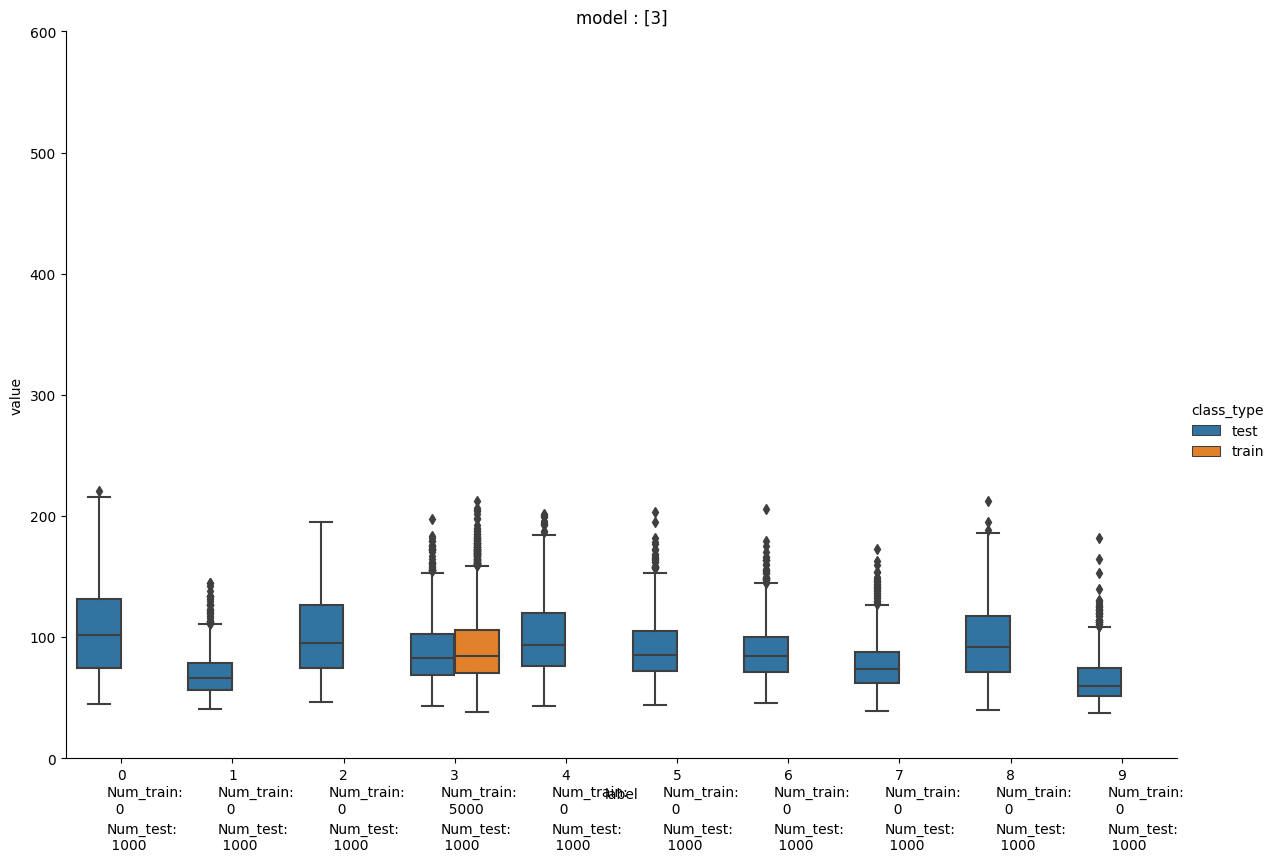

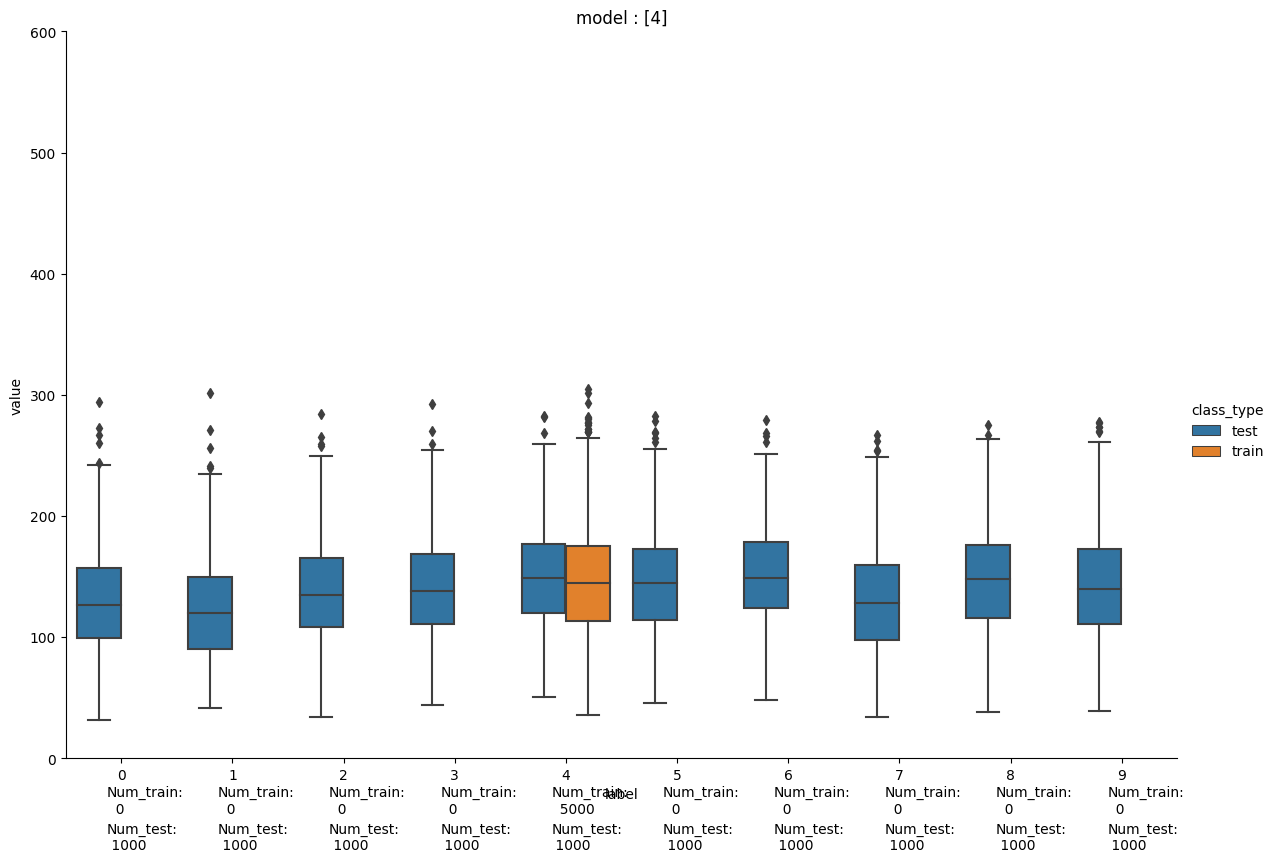

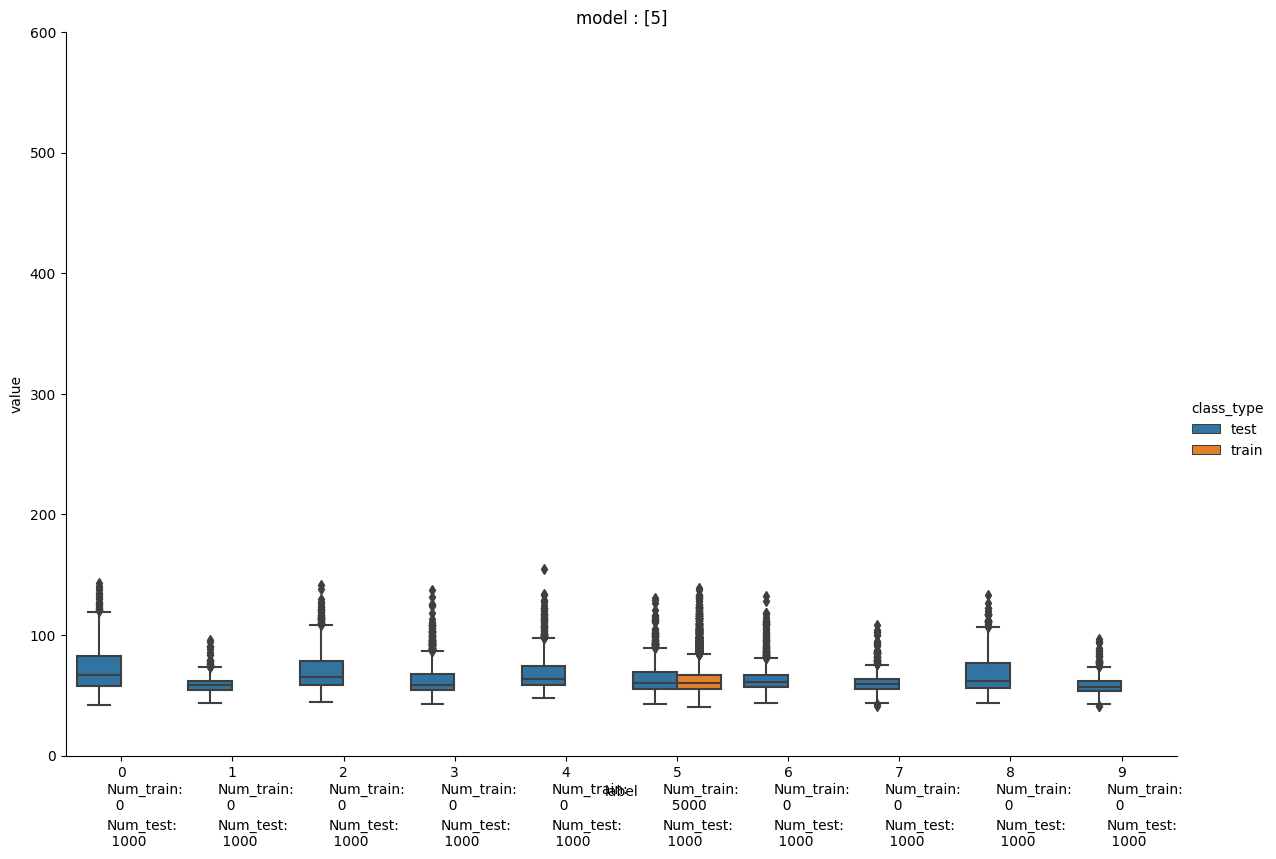

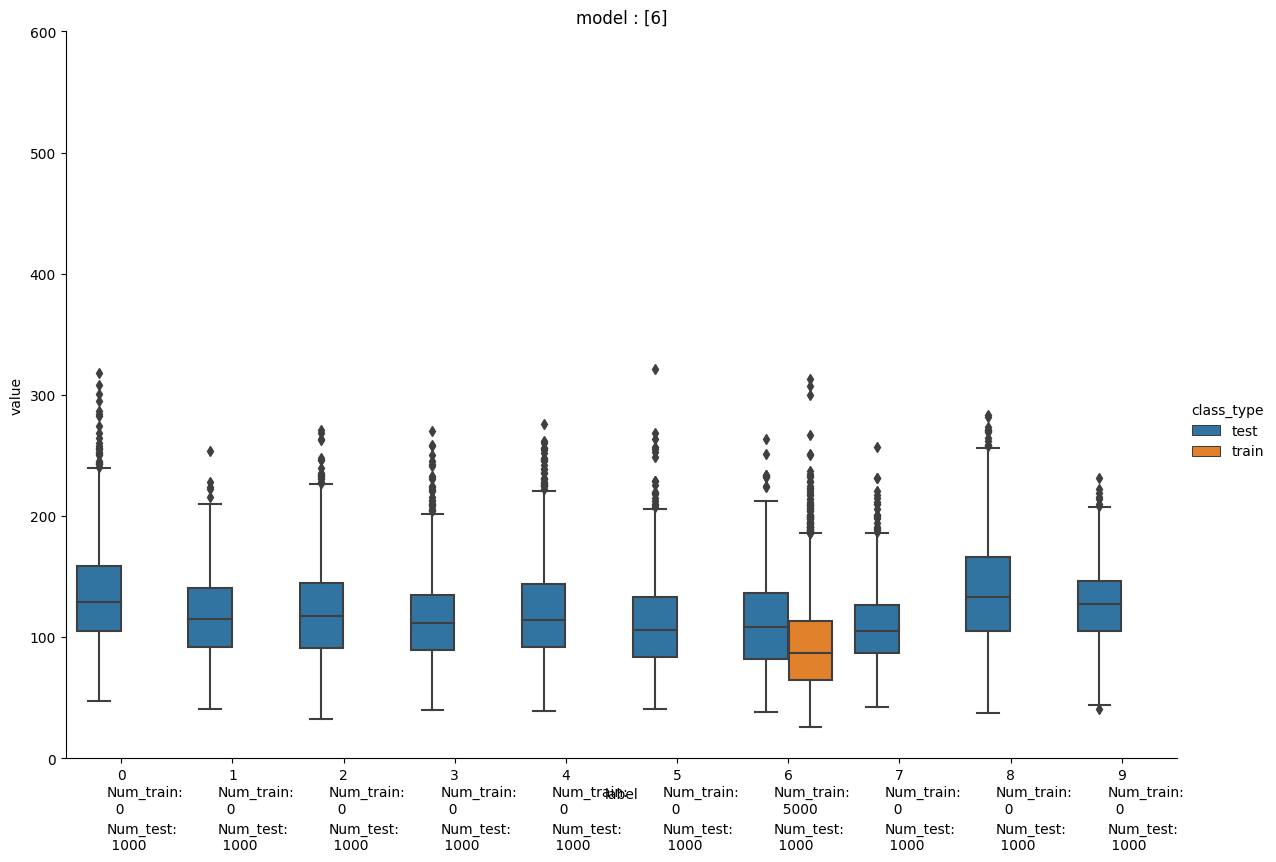

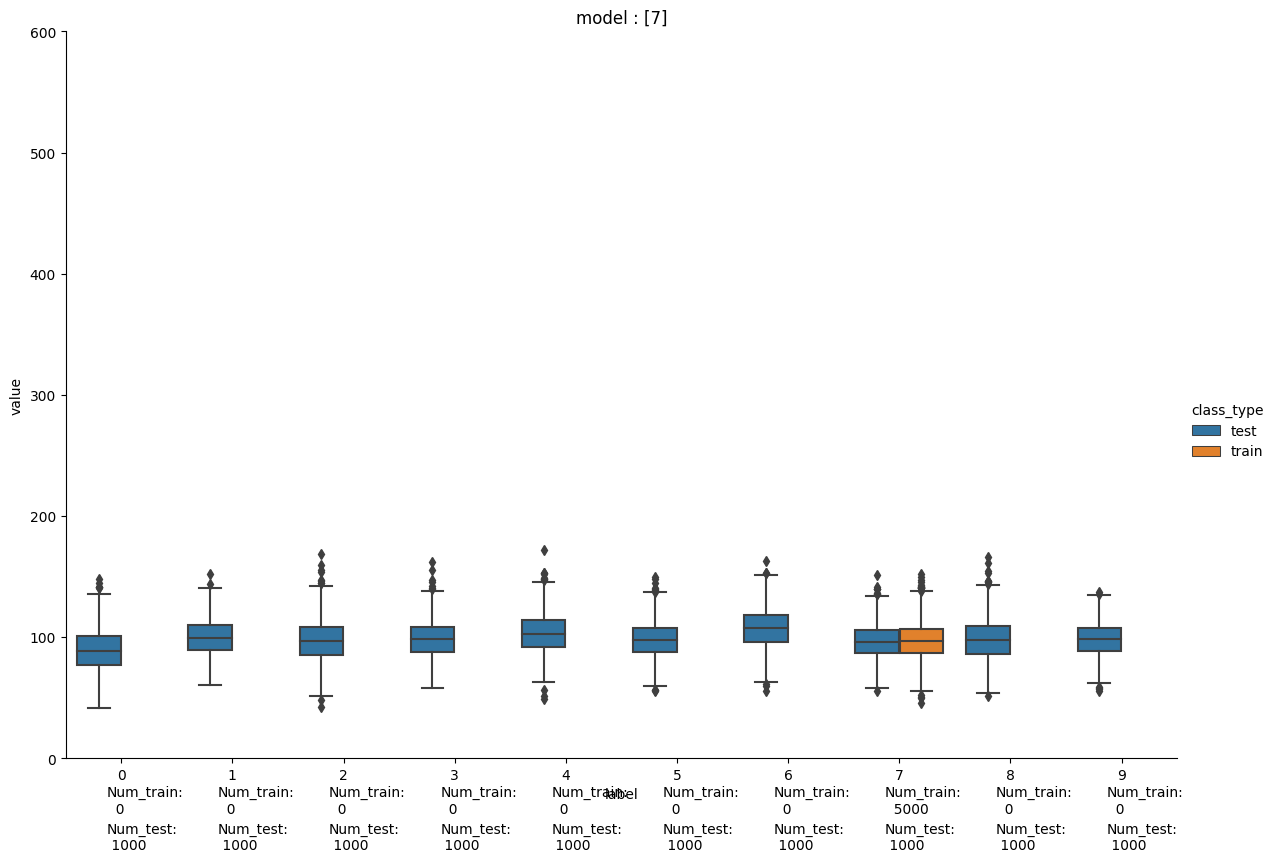

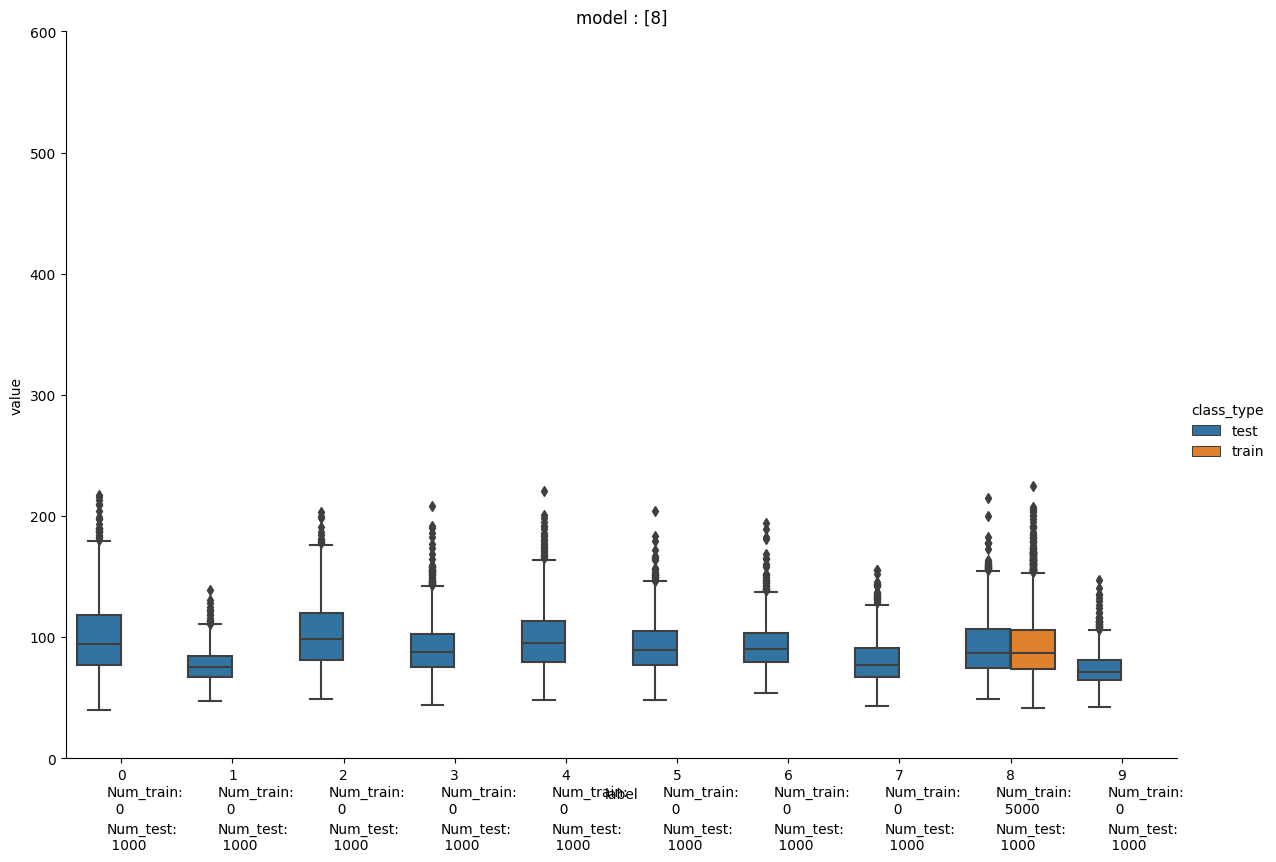

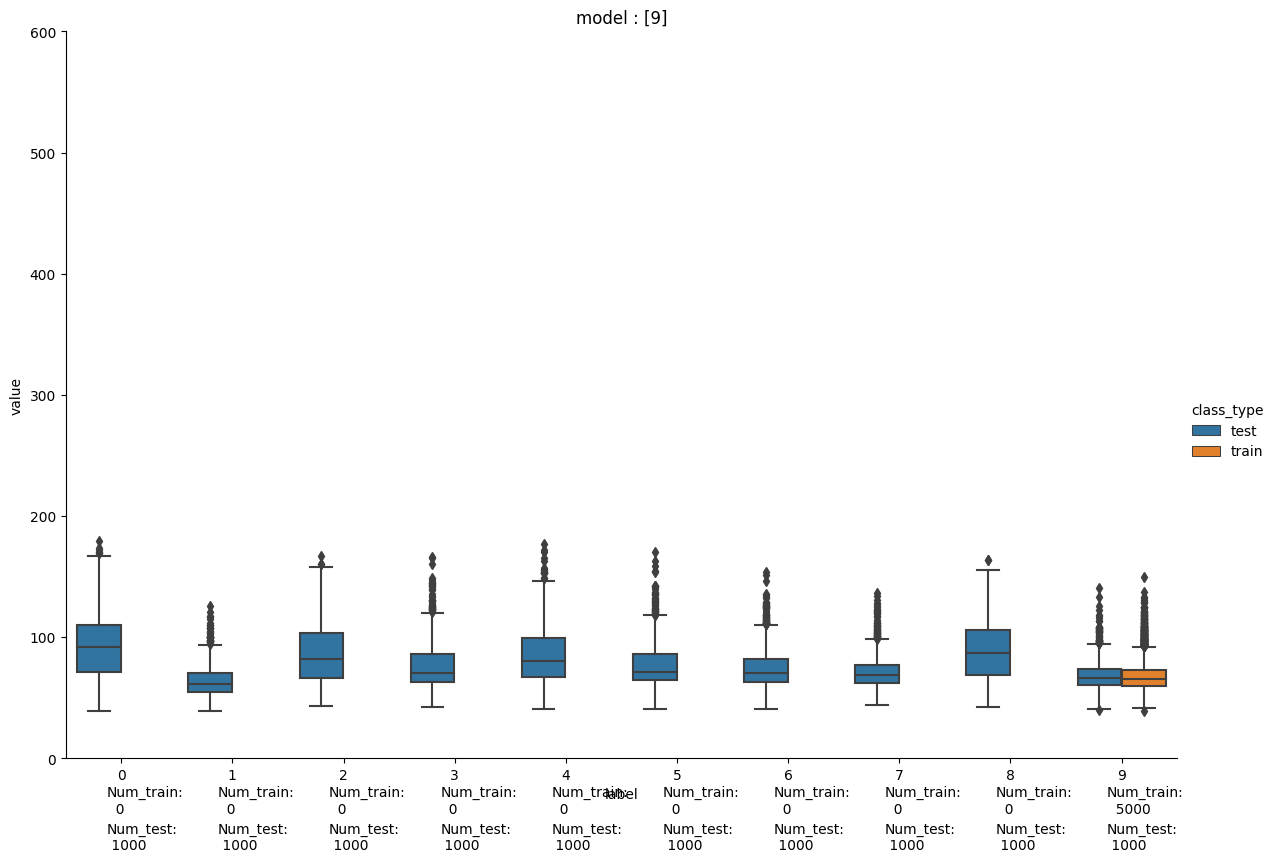

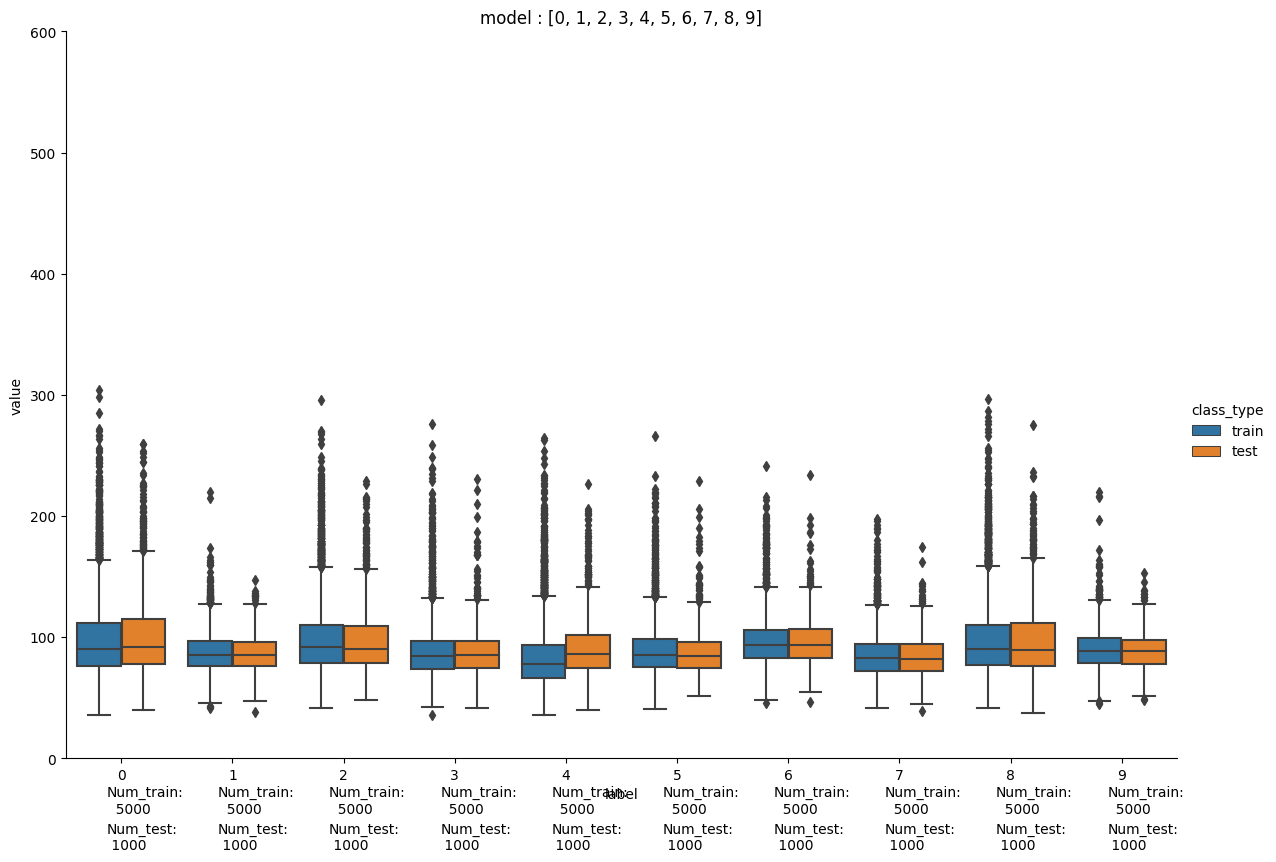

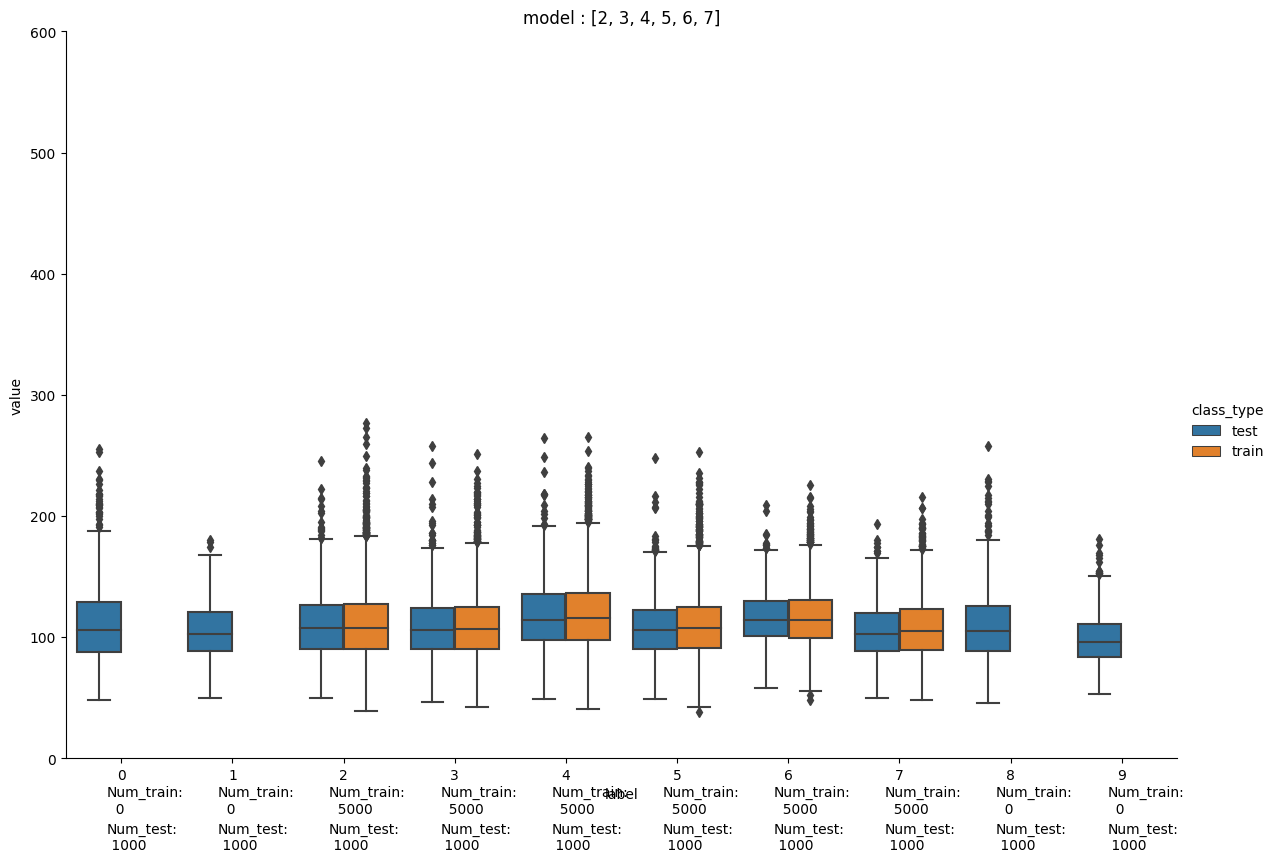

<Figure size 640x480 with 0 Axes>

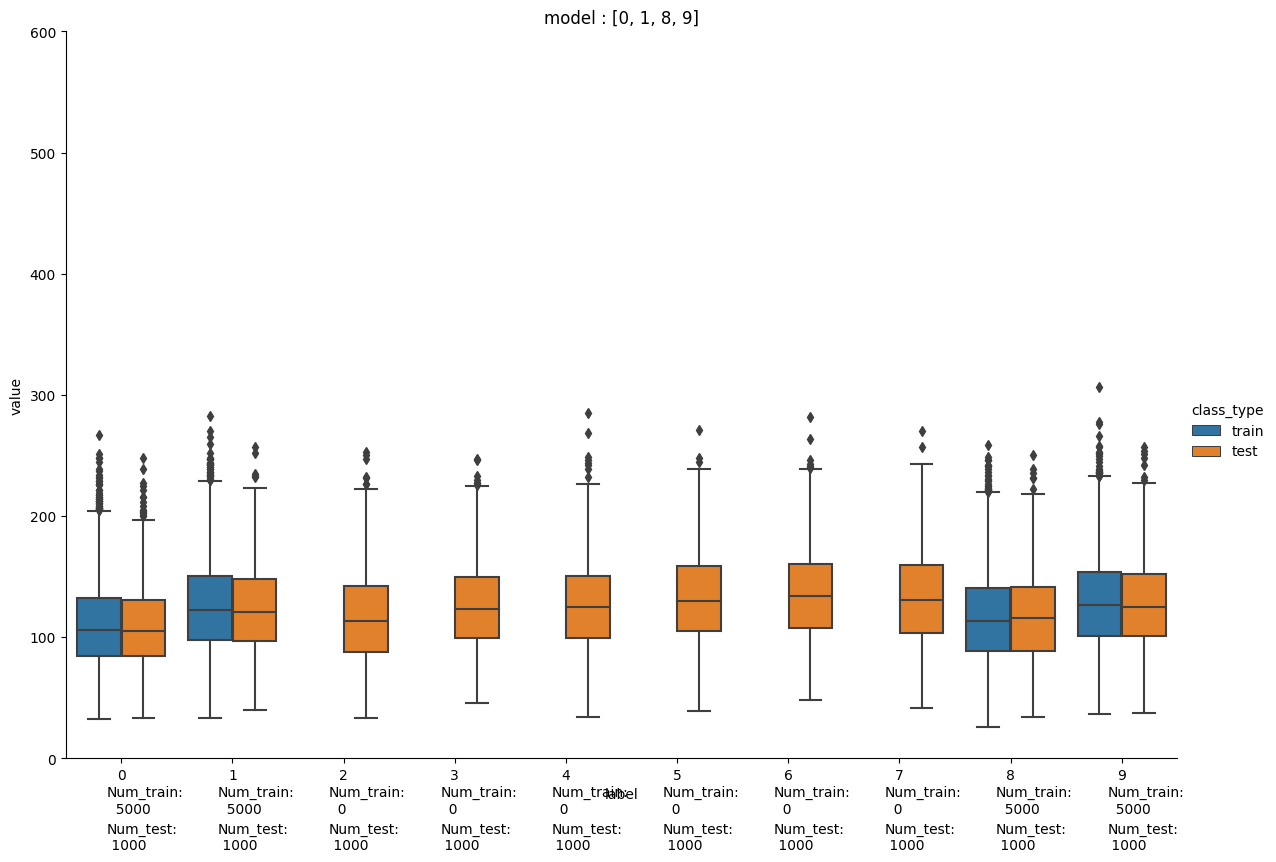

In [12]:
for i in range(len(files)):
    PATH = files[i]
    test_set = test_set
    train_set = train_set_order[i]
    model, train_loader, test_loader = load_trained_model(PATH, train_set, test_set)
    plot_kld(train_loader, test_loader,class_set=test_set, train_set=train_set,test_set=test_set,
         save=True)